In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z

from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit.extensions.unitary import UnitaryGate
from qiskit.circuit.library.standard_gates import CZGate
from qiskit.circuit.library.standard_gates import SGate
from qiskit.circuit.library.standard_gates import CHGate

from qiskit.quantum_info import Statevector

from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
def createEqSuperposCollectiveZ():
    '''
    Defines a quantum circuit to create the uniform superposition of basis elements required.
    '''
    temp = QuantumCircuit(2)
    temp.h(0)
    temp.h(1)
    return temp

In [3]:
'''
Defines a quantum circuit to create a purification of the state to be tested. Purification created on qubits (S, S') - 
3 and 2 qubits respectively
'''
size = 5
state = QuantumCircuit(size)
state.ry(2*np.arccos(1/np.sqrt(3)), 0)
state.append(CHGate(), [0, 1])
state.cx(1, 2)
state.cx(0, 1)
state.x(0)
state.draw()

┌────────────┐               ┌───┐
q_0: ┤ Ry(1.9106) ├──■─────────■──┤ X ├
     └────────────┘┌─┴─┐     ┌─┴─┐└───┘
q_1: ──────────────┤ H ├──■──┤ X ├─────
                   └───┘┌─┴─┐└───┘     
q_2: ───────────────────┤ X ├──────────
                        └───┘          
q_3: ──────────────────────────────────
                                       
q_4: ──────────────────────────────────

In [4]:
def createQuantumCircuit():
    '''
    Creates quantum circuit for the problem. 
    Refer to Appendix G from https://arxiv.org/pdf/2105.12758
    The ciruit contains 7 qubits each labelled as (C, S, S')
    '''  
    circ = QuantumCircuit(7)
    
    superPosCircuit = createEqSuperposCollectiveZ()
    circ.append(superPosCircuit, [0, 1])
    circ.append(state, [2, 3, 4, 5, 6])

    controlledU1 = SGate().control(1)
    circ.append(controlledU1, [1, 2])
    circ.append(controlledU1, [1, 3])
    circ.append(controlledU1, [1, 4])
    
    circ.append(CZGate(), [0, 2])
    circ.append(CZGate(), [0, 3])
    circ.append(CZGate(), [0, 4])
    
    circ.append(superPosCircuit.inverse(), [0, 1])

    return circ

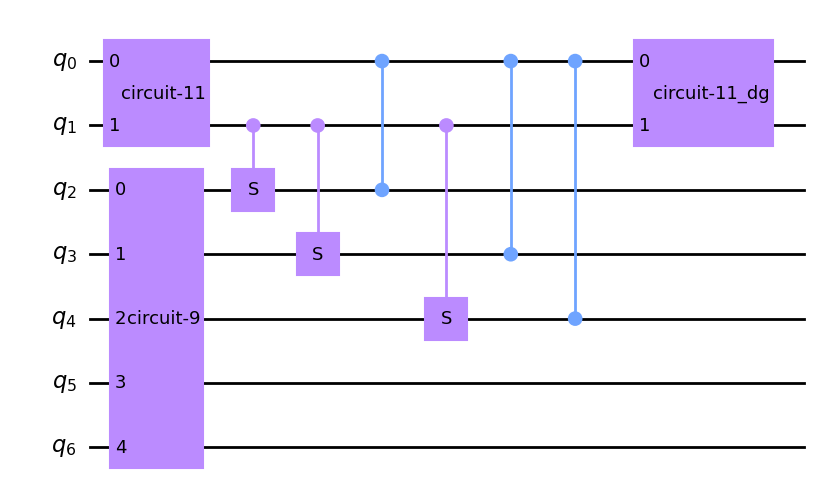

In [5]:
'''
Creates the quantum circuit
'''
qCirc = createQuantumCircuit()
qCirc.draw('mpl')

In [6]:
'''
Pick a backend to use. We use the statevector_simulator for noiseless simulation.
'''
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [11]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation. 
'''
#Replace the provider with your personal credentials for hub, group and main
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")

noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [8]:
'''
Average value of this hamiltonian is the probability of measuring 0 on the first two qubits.
MatrixOp(np.array([[1, 0], [0, 0])) is the projector on the 0 subspace. Qiskit orders qubits in reverse.
'''
hamiltonian = I^I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [9]:
def costf(noisy = False):
    '''
    Calculates the expectation value.
    '''  
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    
    if noisy:
        result = noisy_sampler.convert(expectation).eval()  
    else:
        result = noiseless_sampler.convert(expectation).eval()  
    
    return np.real(result)

In [10]:
print("Cost : ", costf(False))

Cost :  0.0
